# 데이터 준비

In [10]:
import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


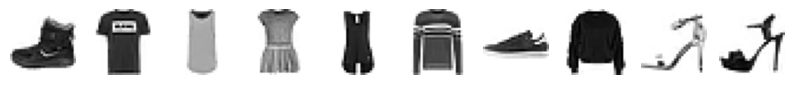

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10,10))
for i in range(10): # 간단히 훈련셋 중 처음 10개의 샘플만 직접 살펴보자.
    ax[i].imshow(train_input[i], cmap='gray_r')
    ax[i].axis('off')
plt.show()

In [15]:
print(train_target[:10])

[9 0 0 3 0 2 7 2 5 5]


- 참고로 fashion_mnist는 아래와 같이 레이블링되어있다.
    - `0:티셔츠 / 1:바지 / 2:스웨터 / 3:드레스 / 4:코트 / 5:샌들 / 6:셔츠 / 7:스니커즈 / 8:가방 / 9:앵클부츠`
- `np.unique`를 통해 각 레이블당 몇 개의 데이터가 있는지도 세어보자.

In [16]:
import numpy as np

print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


### 데이터 전처리
- 4장에서 경사 하강법을 위해서는 각 피쳐를 정규화시켰는데, 그 이유는 피쳐마다 값의 범위가 다르다면 경사 하강의 정도가 피쳐마다 다르기 떄문에 올바른 경사하강법을 수행할 수 없음
- 본 예시에서는 각 픽셀의 값(0~255)을 255로 나누어 0~1사이의 값을 갖도록 만들어줌.
    - 단순히 255로 나눈다고 올바르게 표준화가 되는건 아니지만, 양의 값으로 이루어진 이미지를 전처리할 때 자주 사용되는 방법

In [17]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)
print(train_scaled.shape)

(60000, 784)


---
# 확률적 경사하강법을 통한 성능 측정

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log_loss', max_iter=5, random_state=42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

/Users/hong/anaconda3/envs/AI_Tech_project1/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/hong/anaconda3/envs/AI_Tech_project1/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/hong/anaconda3/envs/AI_Tech_project1/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.8191833333333334


/Users/hong/anaconda3/envs/AI_Tech_project1/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/hong/anaconda3/envs/AI_Tech_project1/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


AttributeError: 'SGDClassifier' object has no attribute 'coef_'

---
# 인공 신경망을 통해 모델 구현하기

### untils code

In [22]:
import keras

keras.config.backend()

'tensorflow'

만약 케라스의 백엔드를 바꾸고싶다면, 아래와 같은 식으로 환경 변수 `KERAS_BACKEND`를 활용하자.

```python
import os 
os.environ['KERAS_BACKEND'] = 'torch'
```

### 데이터셋 준비

In [24]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)